In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters for data generation
sh = int(1e4)  # Number of samples

# Define low and high bounds for each dimension
lows = [0, 0, 1.0, 10, 0.1]  # [t, phi0, omega0, Mc, eta]
highs = [10, 2 * np.pi, 10.0, 80, 0.25]

# Sample uniformly from the 5D space
samples = np.random.uniform(low=lows, high=highs, size=(sh, 5))
results = np.zeros((sh, 2))  # To store [omega(t), phi(t)]

# Define the true system
def true_system(t, y, Mc, eta):
    omega, phi = y
    d_omega = -eta * omega + (1 / Mc) * np.sin(phi)
    d_phi = omega
    return [d_omega, d_phi]
def true_system_torch(omega, phi, Mc, eta):
    d_omega = -eta * omega + (1 / Mc) * torch.sin(phi)
    d_phi = omega
    return d_omega, d_phi
# Solve the system up to t
def get_PHI_omg(t0, phi0, omg0, Mc, eta, t_epoch):
    sol = solve_ivp(
        true_system,
        [t0, t_epoch],
        y0=[omg0, phi0],
        args=(Mc, eta),
        t_eval=[t_epoch],
        rtol=1e-9,
        atol=1e-9
    )
    return sol.y[1, 0], sol.y[0, 0]  # phi(t), omega(t)

In [2]:
# # Loop over all samples and compute the results
# for i in tqdm(range(sh), desc="Generating data"):
#     t, phi0_, omg0_, Mc_, eta_ = samples[i]
#     phi_val, omg_val = get_PHI_omg(t0=0, phi0=phi0_, omg0=omg0_, Mc=Mc_, eta=eta_, t_epoch=t)
#     results[i, 0] = omg_val
#     results[i, 1] = phi_val

# # Reorder input: [t, Mc, eta, omega0, phi0]
# X_data = samples[:, [0, 3, 4, 2, 1]]  # [t, Mc, eta, omega0, phi0]
# Y_data = results  # [omega(t), phi(t)]

# # Convert to torch tensors (float32)
# X_data = torch.tensor(X_data, dtype=torch.float32)
# Y_data = torch.tensor(Y_data, dtype=torch.float32)
# data_tensor = torch.cat([X_data, Y_data], dim=1)
# torch.save(data_tensor, "./data_test.pt")

In [3]:
data_tensor = torch.load("./data_test.pt")  # Shape: (N, 7)

In [4]:
X_data = data_tensor[:, :5]
Y_data = data_tensor[:, 5:]

In [5]:
# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
batch_size=1024

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

# ==== Apply StandardScaler ====
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X_train)
Y_scaled = y_scaler.fit_transform(y_train)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_scaler.transform(X_test), dtype=torch.float32, device=device)
Y_tensor = torch.tensor(Y_scaled, dtype=torch.float32, device=device)
Y_val_tensor = torch.tensor(y_scaler.transform(y_test), dtype=torch.float32, device=device)

# ==== Prepare DataLoader ====
dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
# ==== Define PINN ====
# Define ANN model
class PINN(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=2, num_hidden=4):
        super(PINN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(num_hidden - 1):
            layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU()]
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def physics_loss(self, x_scaled, X_scaler, y_scaler):
        x_scaled = x_scaled.clone().detach().requires_grad_(True)
        y_pred_scaled = self.forward(x_scaled)

        d_y_scaled = torch.autograd.grad(
            outputs=y_pred_scaled,
            inputs=x_scaled,
            grad_outputs=torch.ones_like(y_pred_scaled),
            create_graph=True
        )[0]

        y_std = torch.tensor(y_scaler.scale_, dtype=torch.float32, device=x_scaled.device)
        x_std = torch.tensor(X_scaler.scale_, dtype=torch.float32, device=x_scaled.device)
        correction = y_std[:, None] / x_std[None, :]  # [2, 5]
        d_y_unscaled = d_y_scaled.unsqueeze(1) * correction  # [N, 2, 5]

        d_omega_dt = d_y_unscaled[:, 0, 0:1]
        d_phi_dt = d_y_unscaled[:, 1, 0:1]

        # also compute ground truth from true_system
        x_unscaled = inverse_transform_tensor(x_scaled, X_scaler)
        y_unscaled = inverse_transform_tensor(y_pred_scaled, y_scaler)

        t = x_unscaled[:, 0:1]
        Mc = x_unscaled[:, 3:4]
        eta = x_unscaled[:, 4:5]
        omega = y_unscaled[:, 0:1]
        phi = y_unscaled[:, 1:2]

        d_omega_true, d_phi_true = true_system_torch(omega, phi, Mc, eta)

        criterion = nn.MSELoss()
        ode_loss_omega = criterion(d_omega_dt, d_omega_true)
        ode_loss_phi = criterion(d_phi_dt, d_phi_true)

        return ode_loss_omega, ode_loss_phi, d_omega_dt, d_phi_dt

In [9]:
# ==== Inverse transform for tensor ====
def inverse_transform_tensor(tensor_scaled, scaler):
    device = tensor_scaled.device
    dtype = tensor_scaled.dtype
    scale = torch.tensor(scaler.scale_, dtype=dtype, device=device)
    mean = torch.tensor(scaler.mean_, dtype=dtype, device=device)
    return tensor_scaled * scale + mean

In [10]:
# ==== Train model ====
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # Decay LR by 0.1 every 20 epochs
criterion = nn.MSELoss()

In [11]:
# train_loader = loader
# val_loader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size)

# num_epochs = 80
# train_losses, val_losses = [], []

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     for xb, yb in train_loader:
#         xb, yb = xb.to(device), yb.to(device)
#         loss = criterion(model(xb), yb)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     train_loss = total_loss / len(train_loader)
#     train_losses.append(train_loss)

#     # Validation
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for xb, yb in val_loader:
#             xb, yb = xb.to(device), yb.to(device)
#             val_loss += criterion(model(xb), yb).item() * xb.size(0)
#     val_loss /= len(val_loader.dataset)
#     val_losses.append(val_loss)
#     scheduler.step()

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

#         # Live plot
#         plt.clf()
#         plt.plot(train_losses, label='Train Loss')
#         plt.plot(val_losses, label='Validation Loss')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title('Training vs Validation Loss')
#         plt.legend()
#         plt.pause(0.1)

# plt.show()


Epoch 1/80, Train Loss: 6.876896, Val Loss: 0.958861, ω Loss: 82.856010, φ Loss: 6.457056, IC Loss: 4.407560


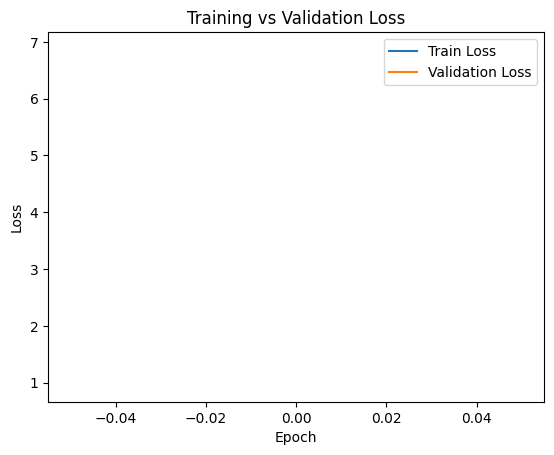

Epoch 11/80, Train Loss: 1.297170, Val Loss: 0.205137, ω Loss: 59.144978, φ Loss: 2.412344, IC Loss: 0.227715


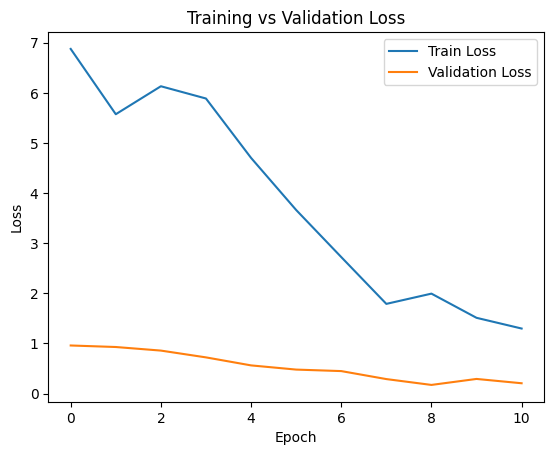

Epoch 21/80, Train Loss: 1.422374, Val Loss: 0.240908, ω Loss: 54.946845, φ Loss: 1.861785, IC Loss: 0.440951


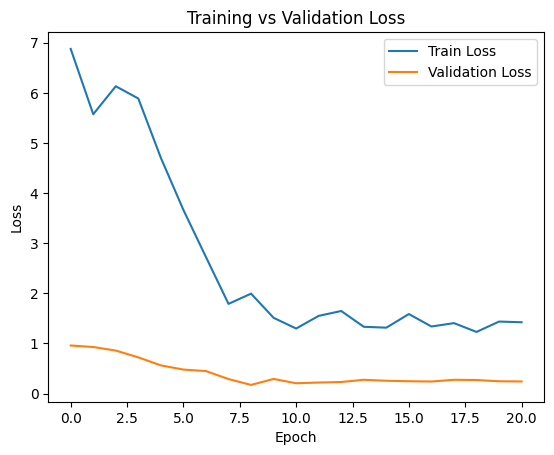

Epoch 31/80, Train Loss: 1.212292, Val Loss: 0.253766, ω Loss: 50.407903, φ Loss: 2.051125, IC Loss: 0.241648


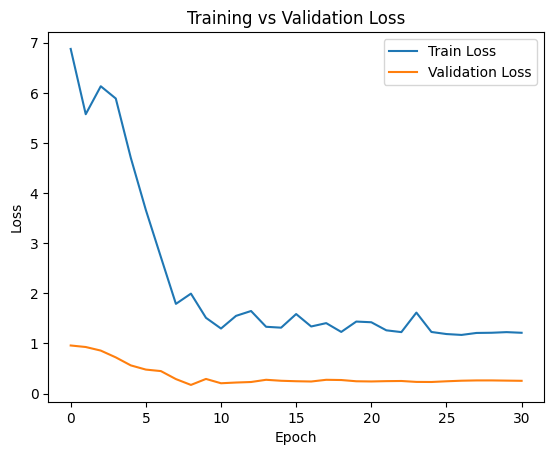

Epoch 41/80, Train Loss: 1.234681, Val Loss: 0.252377, ω Loss: 50.872277, φ Loss: 2.234132, IC Loss: 0.244647


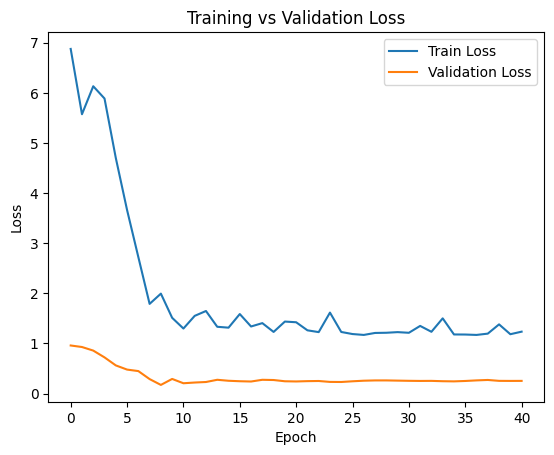

Epoch 51/80, Train Loss: 1.169196, Val Loss: 0.257218, ω Loss: 49.844279, φ Loss: 2.157960, IC Loss: 0.191806


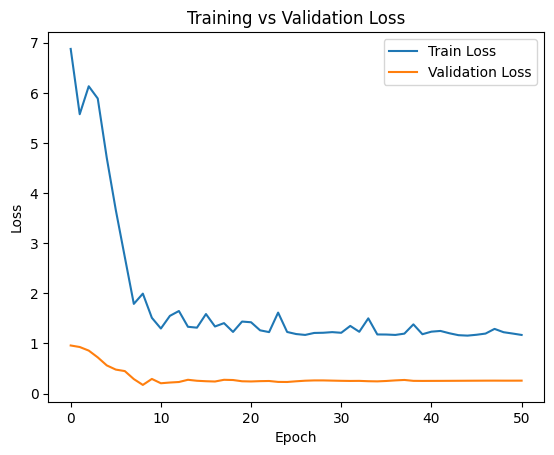

Epoch 61/80, Train Loss: 1.116969, Val Loss: 0.252166, ω Loss: 50.619570, φ Loss: 2.142679, IC Loss: 0.138707


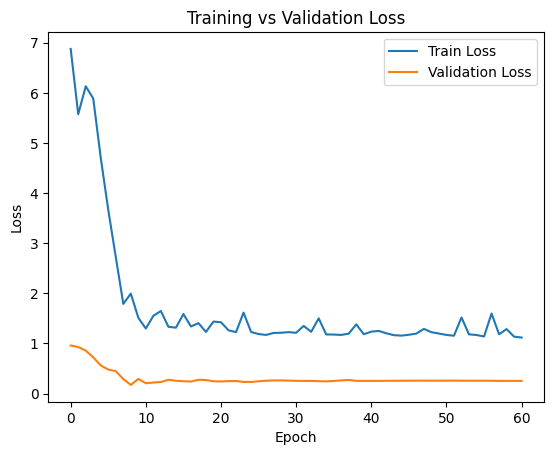

Epoch 71/80, Train Loss: 1.196960, Val Loss: 0.252232, ω Loss: 50.554796, φ Loss: 2.139102, IC Loss: 0.219372


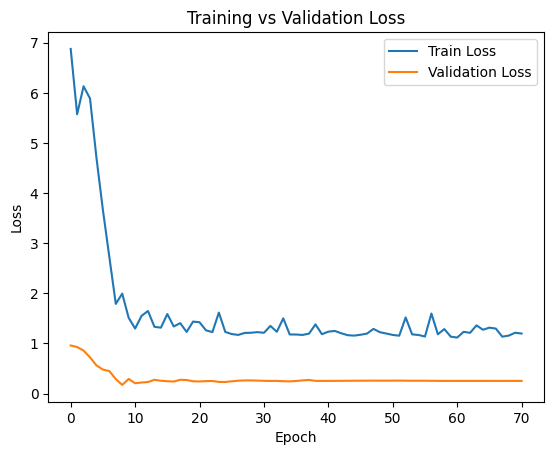

In [12]:
def weighted_ode_loss(ode_loss_omega, ode_loss_phi, weight_omega=1.0, weight_phi=1.0):
    return weight_omega * ode_loss_omega + weight_phi * ode_loss_phi

# Set your desired weights here
omega_weight = 0.1
phi_weight = 1
ic_loss_weight=1
physics_loss_weight = 0.1  # Scaling factor for physics loss in total loss

train_loader = loader
val_loader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size)

num_epochs = 80
train_losses = []
val_losses = []
omega_losses = []
phi_losses = []
ic_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_omega_loss = 0
    total_phi_loss = 0
    total_ic_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        data_loss = criterion(pred, yb)

        ode_loss_omega, ode_loss_phi, d_omega_dt, d_phi_dt = model.physics_loss(xb, X_scaler, y_scaler)
        ode_loss = weighted_ode_loss(ode_loss_omega, ode_loss_phi, omega_weight, phi_weight)

        t0_mask = xb[:, 0] == xb[:, 0].min()
        if t0_mask.any():
            pred_ic = pred[t0_mask]
            true_ic = yb[t0_mask]
            ic_loss = criterion(pred_ic, true_ic)
        else:
            ic_loss = torch.tensor(0.0, device=device)

        loss = data_loss + physics_loss_weight * ode_loss + ic_loss_weight * ic_loss


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_omega_loss += ode_loss_omega.item()
        total_phi_loss += ode_loss_phi.item()
        total_ic_loss += ic_loss.item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    omega_losses.append(total_omega_loss / len(train_loader))
    phi_losses.append(total_phi_loss / len(train_loader))
    avg_ic_loss = total_ic_loss / len(train_loader)
    ic_losses.append(avg_ic_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += criterion(pred, yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.6f}, "
          f"Val Loss: {val_loss:.6f}, "
          f"ω Loss: {omega_losses[-1]:.6f}, "
          f"φ Loss: {phi_losses[-1]:.6f}, "
          f"IC Loss: {avg_ic_loss:.6f}")

        # Live plot
        plt.clf()
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.pause(0.1)

plt.show()


In [13]:
def predict_physical(X_input, model, X_scaler, y_scaler, device):
    """
    Predict physical omega and phi from input [t, phi0, omg0, Mc, eta].

    Parameters:
    - X_input: numpy array of shape [N, 5]
    - model: trained PyTorch model
    - X_scaler: fitted StandardScaler for input
    - y_scaler: fitted StandardScaler for output
    - device: torch device (e.g. 'cuda' or 'cpu')

    Returns:
    - omega_pred: predicted omega values (unscaled)
    - phi_pred: predicted phi values (unscaled)
    """
    # Scale input
    X_scaled = X_scaler.transform(X_input)

    # Convert to tensor
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    # Model prediction
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_tensor)

    # Inverse transform output
    y_pred = y_scaler.inverse_transform(y_pred_scaled.cpu().numpy())

    omega_pred = y_pred[:, 0]
    phi_pred = y_pred[:, 1]

    return omega_pred, phi_pred


In [14]:
(t,phi0, omg0, Mc, eta)=(3.7,np.pi/3,4.3,25,0.2)
X_in=np.array([t, Mc, eta,omg0,phi0]).reshape(1, -1)

In [15]:
get_PHI_omg(0, phi0, omg0, Mc, eta, t)

(np.float64(12.300380357458987), np.float64(2.0346050502223676))

In [16]:
predict_physical(X_in, model, X_scaler, y_scaler, device)

(array([1.6654698], dtype=float32), array([15.331084], dtype=float32))